# Correlation inference for compositional data

In this example, we aim to estimating the correlation matrix $\Sigma$ (assumed to be sparse) of $y\in\mathbb{R}^p$ which is latent (unobservable).

The observable data is the compositional version $x$ of $y$ such that $$x_j=\frac{y_j}{\sum_i y_i}, j=1,\cdots, p.$$

To show the difficulty, we point out that correlation may appears in $x_j$'s even if $y_j$'s are uncorrelated.

However, this task is possible due to the true sparse structure of $\Sigma$, we minimize the following loss function proposed by [Fang et al.](https://academic.oup.com/bioinformatics/article/31/19/3172/211784)$$L(\Sigma)=\frac{1}{2}\|F_0(\Sigma-S)F_0\|_V^2=\frac{1}{2}\mathrm{tr}\left[(F_0(\Sigma-S)F_0^{\top})V(F_0(\Sigma-S)F_0^{\top})\right]$$ where $F_0=I_p-p^{-1}1_p1_p^{\top}$, $S$ is the sample covariance of $\log x$ and $V=\left[\mathrm{diag}(F_0SF_0^{\top})\right]^{-1}$.

To encourage sparsity of $\Sigma$, considering the symmetry and positive-definiteness, we view the elements of the lower triangle entries of $\Sigma$ as the optimized parameter to which we impose the cardinality constraint using ``scope``.

Actually, $\Sigma$ can be represented as the sum of this lower triangle matrix and its transpose (upper triangle matrix). In fact, this procedure enfore symmetry.

Note that, we do not implement a procedure to enfore positive-definiteness. We only check whether this property is satisfied by the resulted estimator. If the resulted estimator is positive definite, we directly output it as the final estimator, otherwise we find a closest positive definite matrix as the final estimator as suggested in [Fang et al.](https://academic.oup.com/bioinformatics/article/31/19/3172/211784).

In [6]:
import numpy as np
np.random.seed(123)
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from scope import ScopeSolver

import warnings
warnings.filterwarnings('ignore')

The simulation data is generated as follows. The dimension of $y$ is $p=50$ and the sample size is $n=500$. The true correlation matrix is constructed with is elements being $\Sigma_{i,j}=0.6^{|i-j|}\mathbb{I}_{\{|i-j|\leq 4\}}, i\neq j$ and $\Sigma_{ii}=1$. We first generate $\log y$ from $\mathcal{N}(0,\Sigma)$ and then $y$ is generated as its exponential. Lastly, we normalize $y$ by dividing its sum to obtain the observable data $x$.

In [7]:
n, p = 500, 50
mu = np.zeros(p)
Sigma = np.zeros((p, p))
for i in range(p):
    for j in range(p):
        if i == j:
            Sigma[i, j] = 1
        elif np.abs(i - j) <= 4:
            Sigma[i, j] = 0.6 ** np.abs(i - j)
Y_log = np.random.multivariate_normal(mu, Sigma, size=n)
Y = np.exp(Y_log)
X = Y / np.sum(Y, axis=1).reshape(-1, 1)
k = int(len((np.nonzero(Sigma)[0]) - p) / 2)  # true sparsity

The following function ``ccscope`` implements the main algorithm of formulated as above.

The sub-function is to transform a vector to a matrix with its lower triangle elements taking the same values as that vector.

In [8]:
def ccscope(X, k):
    n, p = X.shape
    S = jnp.cov(jnp.log(X), rowvar=False)
    F = jnp.eye(p) - jnp.ones((p, 1)) @ jnp.ones((1, p)) / p
    V = jnp.linalg.inv(F @ jnp.diag(jnp.diag(S)) @ F.T)

    def arr_to_cov(arr):
        arr = jnp.array(arr)
        roots = np.poly1d([1, 1, - 2 * len(arr)]).r  # p(p-1)/2 = len(arr)
        dim_cov = int(roots[roots > 0])
        cov = jnp.zeros((dim_cov, dim_cov))
        idx = np.tril_indices(dim_cov, k=0, m=dim_cov)
        cov = cov.at[idx].set(arr)
        cov = cov + jnp.tril(cov, -1).T
        return cov
    
    def custom_objective(params):
        cov = arr_to_cov(params)
        loss = jnp.trace(F @ (cov - S) @ F.T @ V @ F @ (cov - S) @ F.T)
        return loss
    
    solver = ScopeSolver(int(p * (p+1) / 2), k)
    params = solver.solve(custom_objective)

    return arr_to_cov(params)

Since no explicit positive definiteness is imposed to our optimization, we need to check whether the output estimator is positive definite.
Fortunately, it shows that ``Sigma_hat`` is already positive definite.

In [9]:
Sigma_hat = ccscope(X=X, k=k)  # assume the true sparsity is known
print('If estimator is positive definite: ', (np.linalg.eigvals(Sigma_hat) > 0).all())

If estimator is positive definite:  True


The following three subplots show the heatmap of trur correlaration matrix, sample correlation matrix of $\mathbf{y}$ and our estimated correlation matrix.

Note that, our proposed estimator attains much better sparsity structure than the sample correlation.

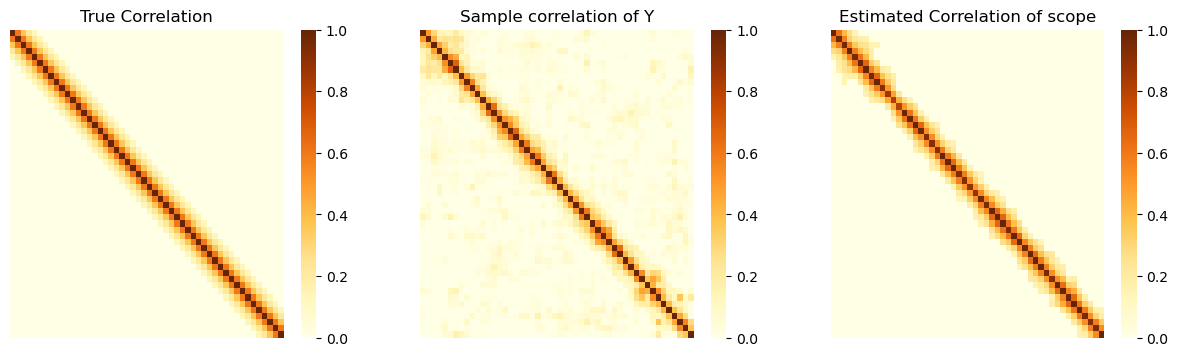

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

sns.heatmap(Sigma, vmin=0, vmax=1, cmap='YlOrBr', ax=ax1)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('True Correlation')

sns.heatmap(np.corrcoef(Y, rowvar=False), vmin=0, vmax=1, cmap='YlOrBr', ax=ax2)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('Sample correlation of Y')

sns.heatmap(Sigma_hat, vmin=0, vmax=1, cmap='YlOrBr', ax=ax3)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_title('Estimated Correlation of scope')

plt.show()

# Reference

- Fang H, Huang C, Zhao H, et al. CCLasso: correlation inference for compositional data through Lasso[J]. Bioinformatics, 2015, 31(19): 3172-3180.